# Aug ??st, 2021

**Motivation**: fig 2 <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Mice

In [2]:
svinet_props = {
    'task': 'rest',
    'mode': 'bold',
    'metric': 'pearson',
    'match_metric': 'euclidean',
    'graph_type': 'real',
}
mice = Mice(Config(128))
mice.combine_dfs(svinet_props.get('task', 'rest'), full=True)

In [3]:
k = 12
p = 20
svinet = SVINET(mice, k, p, 'sub-SLC')
group_dir = get_svinet_group_dir(
    results_dir=mice.cfg.results_dir,
    k=k,
    p=p,
    graph_type=svinet_props.get('graph_type', 'real'),
)
print(group_dir)

current expt: 'p20'

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/gr
oup_results/real-p20-k12

## Load group results

In [4]:
available = [
    e for e in os.listdir(group_dir)
    if '(0.2,1.0;4)' in e
]
file = sorted(available, key=sort_date_latest)[-1]
print(file)

group_bins(0.2,1.0;4)_(2021_08_30).npy

In [5]:
group = np.load(pjoin(group_dir, file), allow_pickle=True).item()

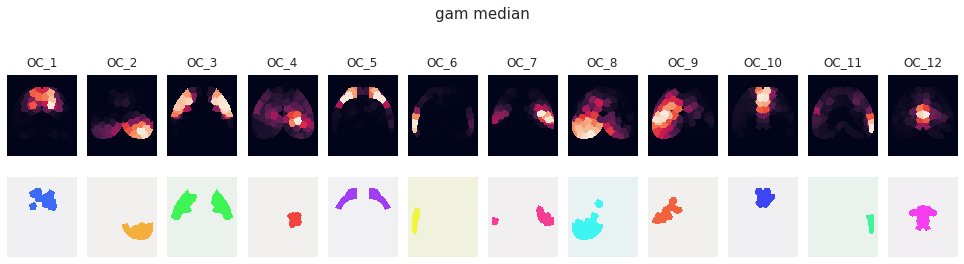

In [6]:
fig, axes = create_figure(2, k, (13.5, 3.8))
gam = np.median(group['gam_all'], 2).mean(1).mean(0)
gam_arr = svinet.pi2arr(gam, cortex_only=True)
masks = svinet.masks_from_pi(gam, disjoint=True, cortex_only=True)
disjoint_arr = {
    idx: project_vol_2d(m, mice.allen['dims_flat'], 'max_proj')
    for idx, m in masks.items()
}
for j in range(k):
    im = axes[0, j].imshow(gam_arr[j + 1], cmap='rocket', vmin=0)
    _ = axes[1, j].imshow(disjoint_arr[j + 1], cmap=svinet.cmaps[j + 1])
    axes[0, j].set_title(f"OC_{j + 1}", y=1.04)
remove_ticks(axes)
fig.suptitle("gam median", fontsize=15, y=1.03)
plt.show()

## Compute $Y_{ij}$

In [7]:
output = compute_node_sim_matrix(group['gam_all'], group['lam_all'])
{k: v.shape for k, v in output.items()}

{
    'y': (10, 138, 138),
    'pi': (10, 12, 138),
    'beta': (10, 12),
    'y_avg': (138, 138),
    'pi_avg': (12, 138),
    'beta_avg': (12,)
}

In [8]:
{k: bool(np.isnan(v).sum()) for k, v in output.items()}

{
    'y': True,
    'pi': True,
    'beta': False,
    'y_avg': False,
    'pi_avg': False,
    'beta_avg': False
}

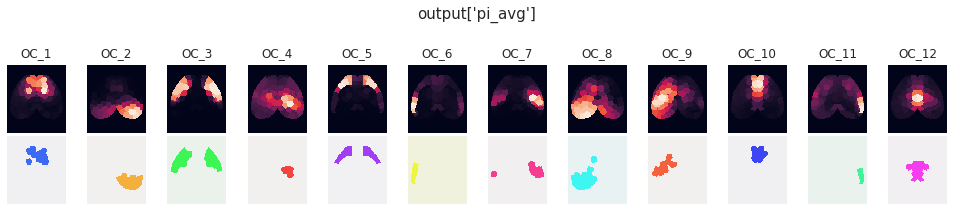

In [9]:
fig, axes = create_figure(2, k, (13.5, 2.8))
pi_arr = svinet.pi2arr(output['pi_avg'], cortex_only=True)
masks = svinet.masks_from_pi(output['pi_avg'], disjoint=True, cortex_only=True)
disjoint_arr = {
    idx: project_vol_2d(m, mice.allen['dims_flat'], 'max_proj')
    for idx, m in masks.items()
}
for j in range(k):
    im = axes[0, j].imshow(pi_arr[j + 1], cmap='rocket', vmin=0)
    _ = axes[1, j].imshow(disjoint_arr[j + 1], cmap=svinet.cmaps[j + 1])
    axes[0, j].set_title(f"OC_{j + 1}", y=1.04)
remove_ticks(axes)
fig.suptitle("output['pi_avg']", fontsize=15, y=1.03)
plt.show()

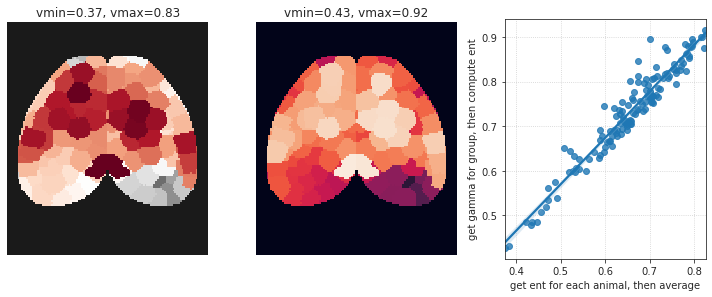

In [10]:
fig, axes = create_figure(1, 3, (10., 4.0))

a = np.nanmean(np.nanmean(group['gam_all'], 2), 1)
eh_avg = np.nanmean(entropy_expect_beta(a), 0)
mask = svinet.pi2arr(eh_avg.reshape(1, -1), cortex_only=True)[1]
axes[0].imshow(mask, vmin=np.min(eh_avg), vmax=np.max(eh_avg), cmap='RdGy_r')
axes[0].set_title(f"vmin={np.min(eh_avg):.2f}, vmax={np.max(eh_avg):.2f}")

a = np.nanmean(np.nanmean(np.nanmean(group['gam_all'], 2), 1), 0)
eh_group = entropy_expect_beta(a)
mask = svinet.pi2arr(eh_group.reshape(1, -1), cortex_only=True)[1]
axes[1].imshow(mask, vmin=np.min(eh_group), vmax=np.max(eh_group))
axes[1].set_title(f"vmin={np.min(eh_group):.2f}, vmax={np.max(eh_group):.2f}")

sns.regplot(eh_avg, eh_group, ax=axes[2])
axes[2].set_xlabel('get ent for each animal, then average')
axes[2].set_ylabel('get gamma for group, then compute ent')
axes[2].set_aspect('equal')
axes[2].grid()

remove_ticks(axes[:2])
plt.show()

## Y_ij

In [10]:
fig, axes = create_figure(20, k, (13.5, 2.4 * 10))

for i in range(10):
    pi_arr = svinet.pi2arr(output['pi'][i], cortex_only=True)
    masks = svinet.masks_from_pi(output['pi'][i], disjoint=True, cortex_only=True)
    disjoint_arr = {
        idx: project_vol_2d(m, mice.allen['dims_flat'], 'max_proj')
        for idx, m in masks.items()
    }
    for j in range(k):
        im = axes[i * 2 + 0, j].imshow(pi_arr[j + 1], cmap='rocket', vmin=0)
        _ = axes[i * 2 + 1, j].imshow(disjoint_arr[j + 1], cmap=svinet.cmaps[j + 1])
        if i == 0:
            axes[0, j].set_title(f"OC_{j + 1}", fontsize=13, y=1.05)
    axes[i * 2 + 0, 0].set_ylabel(f"{mice.get_key(i+1)}\nmemberships\n", fontsize=12)
    axes[i * 2 + 1, 0].set_ylabel(f"{mice.get_key(i+1)}\ndisjoint\n", fontsize=12)
remove_ticks(axes)
sup = fig.suptitle(f"k = {k}, p = {p}, all communities", fontsize=25, y=1.01)
save_fig(fig, sup, pjoin(tmp_dir, f"k{k}_all_comms.pdf"))

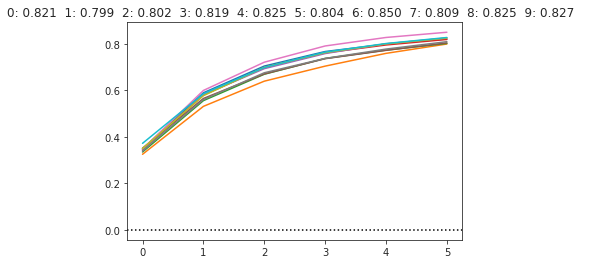

In [42]:
from sklearn.decomposition import PCA

pcs = []
ttl = ''
for i in range(10):
    pi_vol = svinet.pi2vol(output['y'][i], cortex_only=True)
    mask = functools.reduce(np.logical_or, [e != 0 for e in pi_vol.values()])
    x_list = filter_boundaries(list(pi_vol.values()), mask=mask)
    x = [np.expand_dims(e, axis=0) for e in x_list]
    x = np.concatenate(x)
    nans = np.isnan(x).sum(-1).astype(bool)
    pca = PCA(n_components=6, svd_solver='full', random_state=0).fit(x[~nans])
    comps = pca.components_.copy()
    pcs.append(comps)
    
    data2plt = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(data2plt, color=f"C{i}")
    ttl += f'{i}: {data2plt[-1]:.3f}  '
plt.title(ttl)
plt.axhline(0, ls=':', color='k')
plt.show()

((138, 138), (138, 85, 54, 102))

In [29]:
"""y_arr = svinet.pi2arr(y_flat, cortex_only=True)
mask = functools.reduce(np.logical_or, [e != 0 for e in y_arr.values()])

a_list = filter_boundaries(list(y_arr.values()), mask=mask)
a = [np.expand_dims(e, axis=0) for e in a_list]
a = np.concatenate(a)
a.shape"""

(139, 85, 102)

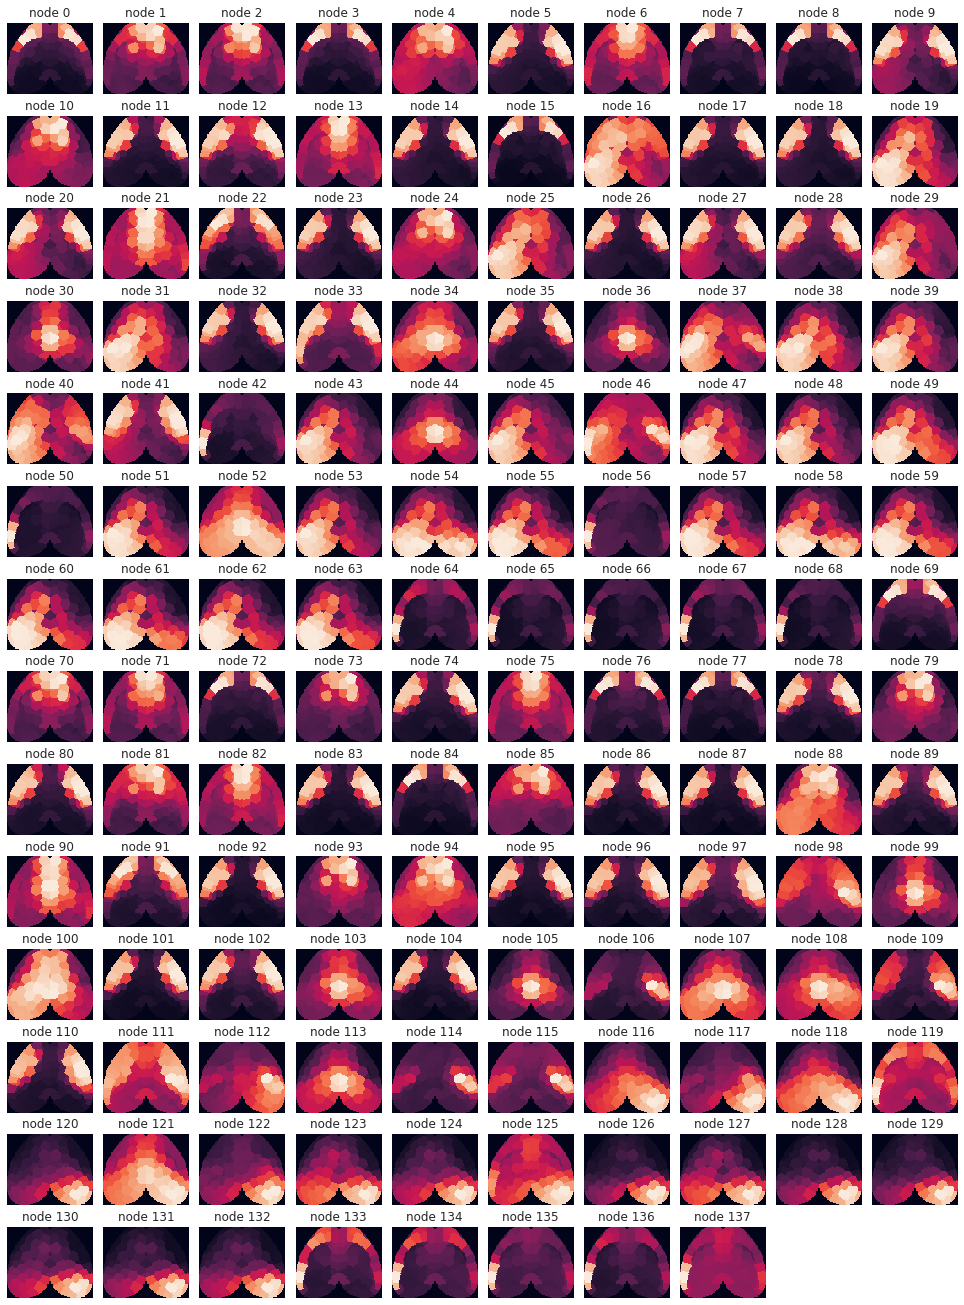

In [31]:
"""nrows = 14
ncols = int(np.ceil(len(a) / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 1.3 * nrows))
for i, ax in zip(range(len(a)), axes.ravel()):
    ax.imshow(a[i])
    ax.set_title(f"node {i}")
trim_axs(axes, len(x))
remove_ticks(axes)
plt.show()"""

  0%|          | 0/10 [00:00<?, ?it/s]

TypeError: list indices must be integers or slices, not tuple

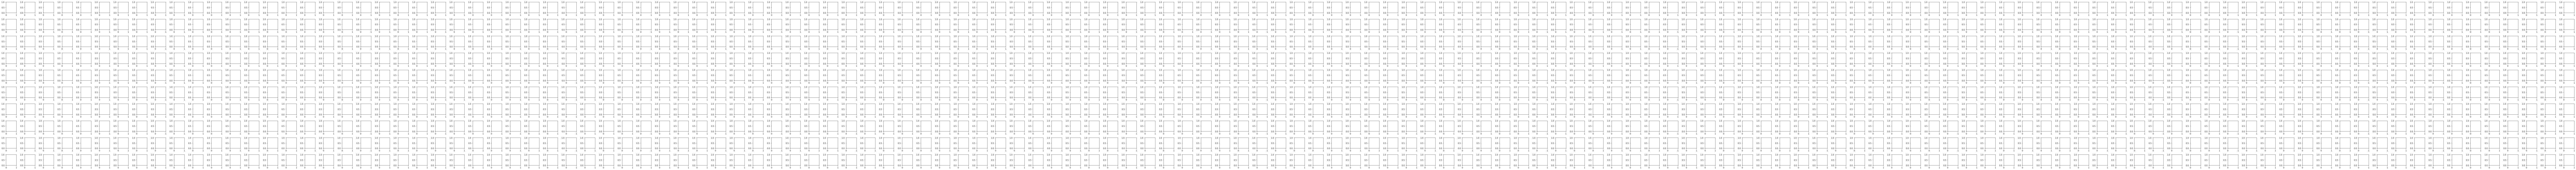

In [12]:
"""nrows = 10
ncols = pi_real.shape[-1]
fig, axes = create_figure(nrows, ncols, (180, 1.2 * nrows))

for i in tqdm(range(nrows)):
    for j in range(ncols):
        axes[i, j].imshow(x_all[i, j])
        if i == 0:
            axes[i, j].set_title(f"node {j}", fontsize=15, y=1.07)
        if j == 0:
            axes[i, j].set_ylabel(f"{mice.get_key(i+1)}\n", fontsize=12)
remove_ticks(axes)
sup = fig.suptitle(f"k = {k}, p = {p}, all communities", fontsize=25, y=1.01)
save_fig(fig, sup, pjoin(tmp_dir, f"k{k}_all_node_sim.pdf"))"""

In [9]:
from sklearn.decomposition import PCA

In [10]:
y_flat = output['y_avg'].copy() # reshape(-1, output['y_avg'].shape[-1])
pi_vol = svinet.pi2vol(y_flat, cortex_only=True)
mask = functools.reduce(np.logical_or, [e > 0 for e in pi_vol.values()])
x_list = filter_boundaries(list(pi_vol.values()), mask=mask)
x = [np.expand_dims(e, axis=0) for e in x_list]
x = np.concatenate(x)
y_flat.shape, x.shape

((138, 138), (138, 85, 54, 102))

In [11]:
nans = np.isnan(x).sum(-1).sum(-1).sum(-1).astype(bool)
pca = PCA(n_components=20, svd_solver='full').fit(x.reshape(len(x), -1)[~nans])
comps = pca.components_.reshape((-1, *x.shape[1:])).copy()
comps.shape

(20, 85, 54, 102)

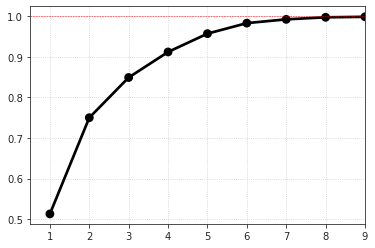

In [12]:
data2plt = np.cumsum(pca.explained_variance_ratio_)
data2plt = {i + 1: j for i, j in enumerate(data2plt)}
data2plt = pd.Series(data=data2plt, index=range(1, 1 + len(data2plt)))
sns.pointplot(x=data2plt.index, y=data2plt.values, color='k')
plt.axhline(1.0, color='r', ls='--', lw=0.5)
plt.xlim(-0.5, 8)
plt.grid()

In [13]:
y_flat.shape, np.isnan(y_flat).sum()

((138, 138), 0)

In [20]:
n_clusters = 5

comps, model = fit_kmeans(
    data=y_flat,
    n_clusters=n_clusters,
    match_metric='euclidean',
    random_state=mice.cfg.random_state,
)
comps /= comps.sum(0, keepdims=True)
masks_mv = svinet.masks_from_pi(comps, disjoint=True, cortex_only=True)
masks_mv = dict(list(masks_mv.items())[:n_clusters])
gmap = align_centroid_to_structs(
    struct_ids=svinet.struct_ids[:n_clusters],
    masks_mv=masks_mv,
    dist_metric='dice',
    global_order=True,
    allen=mice.allen,
)[:n_clusters]
comps = comps[gmap]
comps.shape

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


(5, 138)

In [21]:
comps_vol = svinet.to_vol(comps, cortex_only=True)
comps_2d = {
    idx: project_vol_2d(m, mice.allen['dims_flat'], 'max_proj')
    for idx, m in comps_vol.items()
}

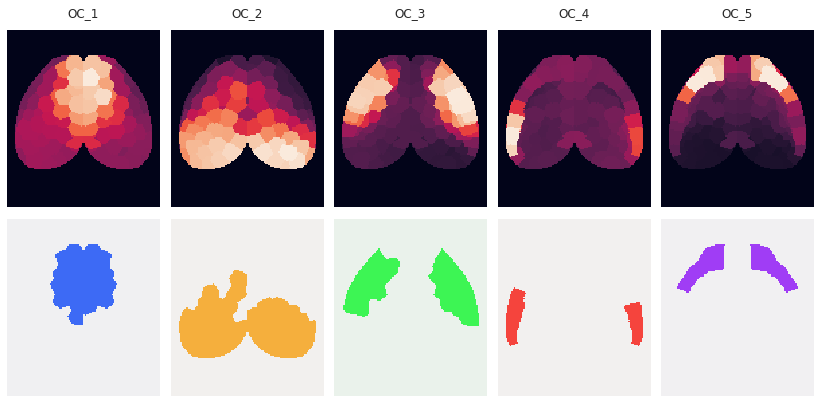

In [23]:
fig, axes = create_figure(2, len(comps), (11.5, 5.8))
pi_arr = svinet.pi2arr(comps, cortex_only=True)
masks = svinet.masks_from_pi(comps, disjoint=True, cortex_only=True)
disjoint_arr = {
    idx: project_vol_2d(m, mice.allen['dims_flat'], 'max_proj')
    for idx, m in masks.items()
}
for j in range(len(comps)):
    im = axes[0, j].imshow(pi_arr[j + 1], cmap='rocket', vmin=0)
    _ = axes[1, j].imshow(disjoint_arr[j + 1], cmap=svinet.cmaps[j + 1])
    axes[0, j].set_title(f"OC_{j + 1}", y=1.04)
remove_ticks(axes)
plt.show()

<matplotlib.colorbar.Colorbar object at 0x7ff8c82509a0>

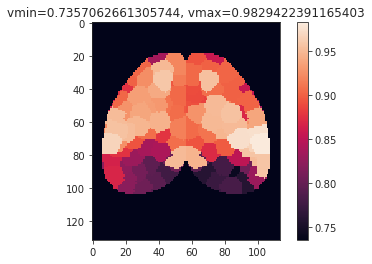

In [24]:
h = sp_stats.entropy(comps, axis=0) / np.log(len(comps))
mask = svinet.pi2arr(h.reshape(1, -1), cortex_only=True)[1]
plt.imshow(mask, vmin=min(h), vmax=max(h))
plt.title(f"vmin={min(h)}, vmax={max(h)}")
plt.colorbar()

In [25]:
def map2interval(
    x: np.ndarray,
    interval: Tuple[float, float] = (0., 1.), ):
    
    a = interval[1] / (np.max(x) - np.min(x))
    b = - a * np.min(x)
    
    return a * x + b

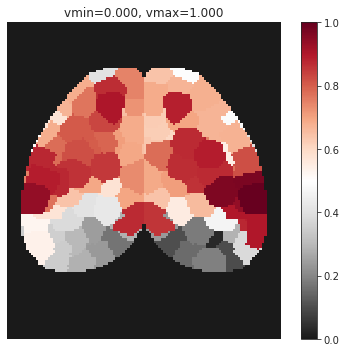

In [26]:
fig, ax = create_figure(1, 1, (6, 5))

h = sp_stats.entropy(comps, axis=0) / np.log(len(comps))
h = map2interval(h)
mask = svinet.pi2arr(h.reshape(1, -1), cortex_only=True)[1]
im = ax.imshow(mask, vmin=min(h), vmax=max(h), cmap='RdGy_r')
plt.colorbar(im, ax=ax)
ax.set_title(f"vmin={min(h):0.3f}, vmax={max(h):0.3f}")
remove_ticks(ax)


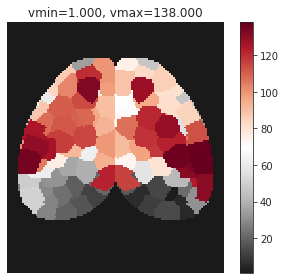

In [27]:
fig, ax = create_figure(1, 1, (5, 4))

h = sp_stats.entropy(comps, axis=0) / np.log(len(comps))
hr = sp_stats.rankdata(h)
mask = svinet.pi2arr(hr.reshape(1, -1), cortex_only=True)[1]
im = ax.imshow(mask, vmin=min(hr), vmax=max(hr), cmap='RdGy_r')
plt.colorbar(im, ax=ax)
ax.set_title(f"vmin={min(hr):0.3f}, vmax={max(hr):0.3f}")
remove_ticks(ax)


<AxesSubplot:ylabel='Count'>

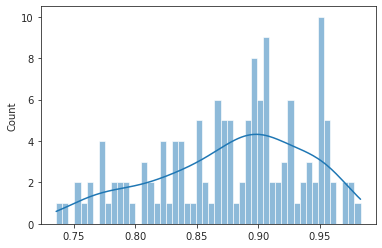

In [28]:
sns.histplot(h, bins=50, kde=True)

In [29]:
hemis = np.array(['R'] * len(svinet.n2l))
hemis[svinet.l_ids] = 'L'

In [30]:
from sklearn.manifold import TSNE
y_emb = TSNE(
    n_components=2,
    perplexity=30,
    random_state=mice.cfg.random_state,
).fit_transform(y_flat)

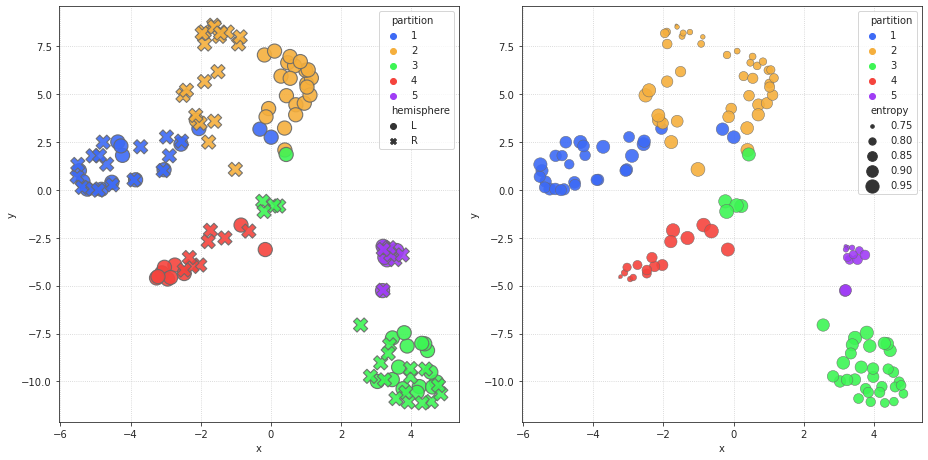

In [31]:
fig, axes = create_figure(1, 2, (13, 6.5), 'ticks')

_df = pd.DataFrame({
    'x': y_emb[:, 0],
    'y': y_emb[:, 1],
    'partition': 1 + np.argmax(comps, axis=0),
    'hemisphere': hemis,
    'entropy': h,
})
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    style='hemisphere',
    palette=svinet.colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[0],
)
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    size='entropy',
    sizes=(1, 200),
    palette=svinet.colors,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[1],
)

for ax in axes.ravel():
    ax.grid()
plt.show()

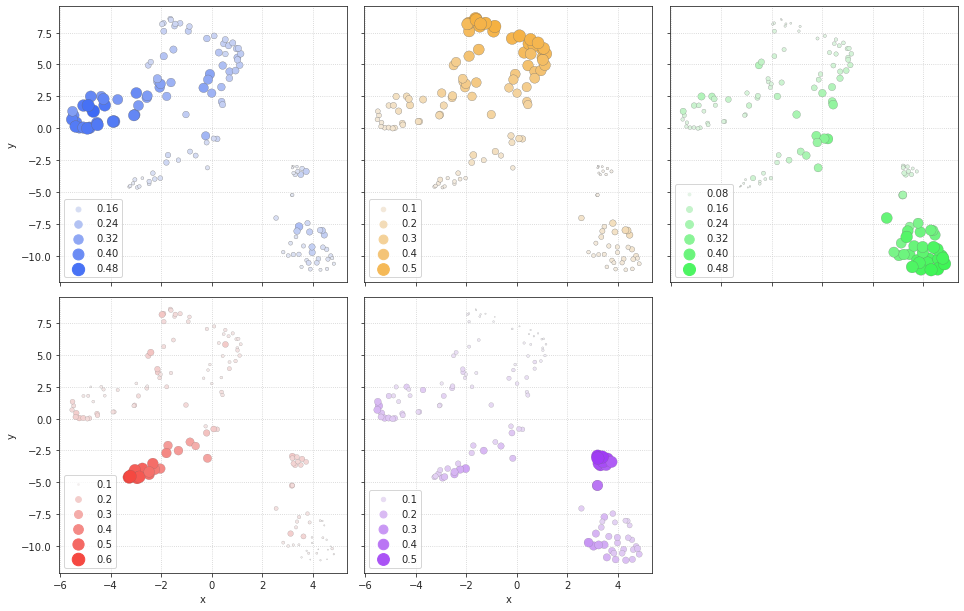

In [32]:
nrows = 2
ncols = int(np.ceil(n_clusters / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 4.3 * nrows), 'ticks', 'all', 'all')

for i, ax in enumerate(axes.ravel()):
    if i == n_clusters:
        break
    _df = pd.DataFrame({
        'x': y_emb[:, 0],
        'y': y_emb[:, 1],
        'hemisphere': hemis,
        'strength': comps[i, :],
    })
    sns.scatterplot(
        data=_df,
        x='x',
        y='y',
        hue='strength',
        size='strength',
        sizes=(1, 160),
        palette=svinet.cmaps[i+1],
        s=120,
        edgecolor='dimgrey',
        ax=ax,
    )
    ax.legend(loc="lower left")
    ax.grid()
trim_axs(axes, n_clusters)
plt.show()

In [33]:
a = np.nanmean(np.nanmean(group['gam_all'],  2), 1)
eh_avg = np.nanmean(entropy_expect_beta(a), 0)
eh_avg = map2interval(eh_avg)

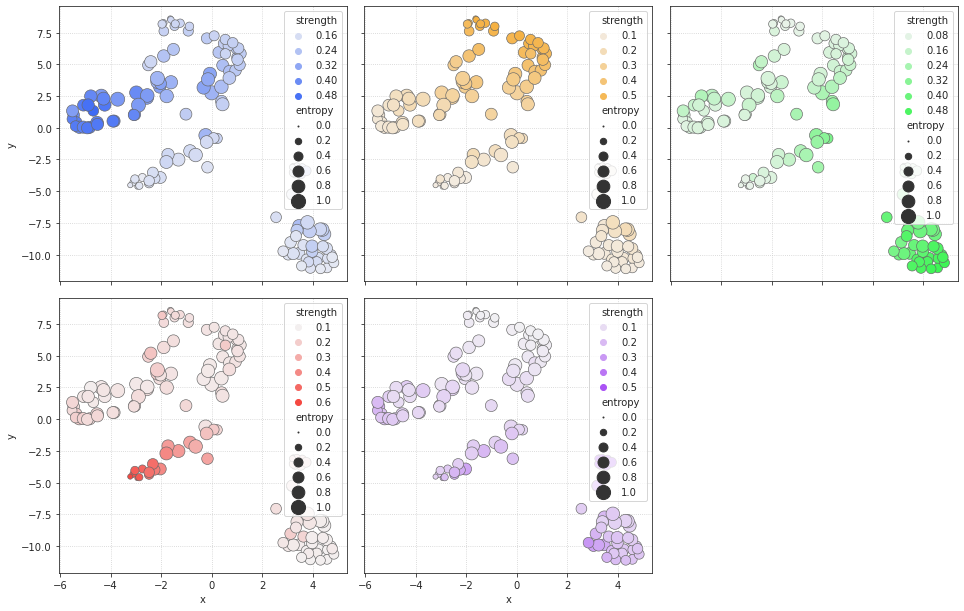

In [34]:
nrows = 2
ncols = int(np.ceil(n_clusters / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 4.3 * nrows), 'ticks', 'all', 'all')

for i, ax in enumerate(axes.ravel()):
    if i == n_clusters:
        break
    _df = pd.DataFrame({
        'x': y_emb[:, 0],
        'y': y_emb[:, 1],
        'strength': comps[i, :],
        'entropy': eh_avg,
    })
    sns.scatterplot(
        data=_df,
        x='x',
        y='y',
        hue='strength',
        size='entropy',
        sizes=(1, 200),
        palette=svinet.cmaps[i+1],
        edgecolor='dimgrey',
        ax=ax,
    )
    ax.grid()
trim_axs(axes, n_clusters)
plt.show()

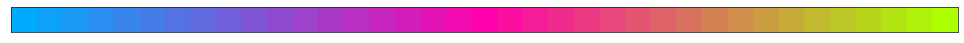

In [35]:
ramp_colors = ['#00abff', '#ff00ab', '#abff00']
cmap = make_cmap(ramp_colors, name='overlap')

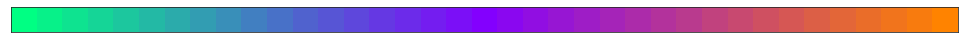

In [36]:
ramp_colors = ['#00ff83', '#8300ff', '#ff8300']
cmap = make_cmap(ramp_colors, name='overlap')

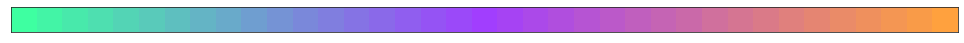

In [37]:
ramp_colors = ['#3effa1', '#a13eff', '#ffa13e']
cmap = make_cmap(ramp_colors, name='overlap')

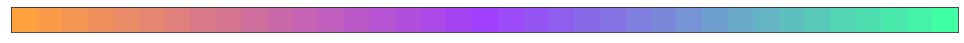

In [38]:
ramp_colors = ['#ffa13e', '#a13eff', '#3effa1']
cmap = make_cmap(ramp_colors, name='overlap')

In [39]:
comps.shape

(5, 138)

In [40]:
comps[:, 50]

array([0.12819179, 0.090336  , 0.07076678, 0.56750214, 0.14320329])

In [41]:
comps_condensed = np.zeros((3, comps.shape[-1]))
comps_condensed[0] = comps[1]
comps_condensed[1] = comps[0] + comps[3:].sum(0)
comps_condensed[2] = comps[2]

[
    <matplotlib.lines.Line2D object at 0x7ff9171dcd90>,
    <matplotlib.lines.Line2D object at 0x7ff9171dcbb0>,
    <matplotlib.lines.Line2D object at 0x7ff9171dc9a0>
]

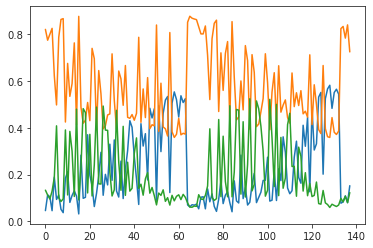

In [42]:
plt.plot(comps_condensed.T)

In [43]:
partition = np.argmax(comps, axis=0)

h = sp_stats.entropy(comps, axis=0) / np.log(len(comps))
h = map2interval(h)
sord_ids = np.argsort(h)

[
    <matplotlib.lines.Line2D object at 0x7ff9129c2b50>,
    <matplotlib.lines.Line2D object at 0x7ff9129c2c40>,
    <matplotlib.lines.Line2D object at 0x7ff9129c2d00>
]

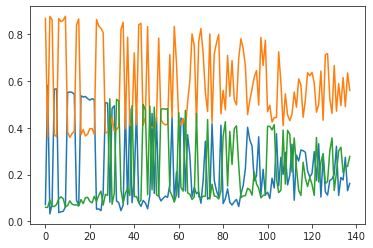

In [44]:
plt.plot(comps_condensed.T[sord_ids])

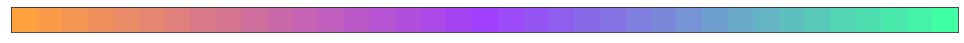

In [45]:
ramp_colors = ['#ffa13e', '#a13eff', '#3effa1']
cmap = make_cmap(ramp_colors, name='overlap')

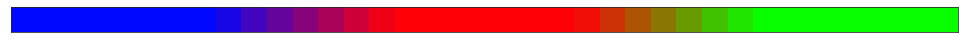

In [46]:
repeat = 2
# ramp_colors = ['#ffa13e', '#a13eff', '#3effa1']
ramp_colors = ['#0007ff', '#ff0007', '#07ff00']
# ramp_colors = ['#f5af3d', '#af3df5', '#3df5af']
# ramp_colors = ['#fffe00', '#fe00ff', '#00fffe']
cmap = make_cmap(np.repeat(ramp_colors, repeat), name='overlap')

In [47]:
vals = {}
colors = {}
for node in range(comps_condensed.shape[-1]):
    ids = np.argsort(comps_condensed[:, node])[::-1]
    a, b = comps_condensed[:, node][ids][:2]
    val = b / (a + b)
    ramp = [ramp_colors[ids[0]]] * repeat + [ramp_colors[ids[1]]] * repeat
    _cmap = make_cmap(ramp, show=False)
    colors[node] = rgb2hex(_cmap(val))
    vals[node] = val

<AxesSubplot:ylabel='Density'>

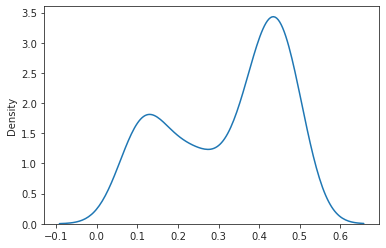

In [48]:
sns.kdeplot(vals.values())

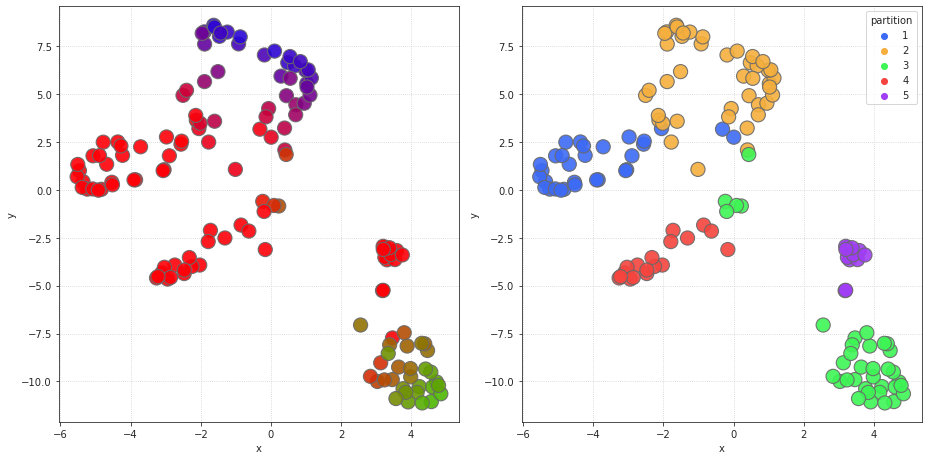

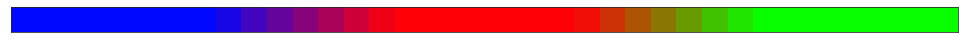

In [49]:
fig, axes = create_figure(1, 2, (13, 6.5), 'ticks')

_df = pd.DataFrame({
    'node': range(len(y_emb)),
    'x': y_emb[:, 0],
    'y': y_emb[:, 1],
    'partition': 1 + np.argmax(comps, axis=0),
    'hemisphere': hemis,
    'entropy': h,
})
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='node',
    palette=colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    legend=False,
    ax=axes[0],
)
s = sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    palette=svinet.colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[1],
)

for ax in axes.ravel():
    ax.grid()
plt.show()
display_cmap(cmap)

In [50]:
vals = {}
colors = {}
for node in range(comps.shape[-1]):
    ids = np.argsort(comps[:, node])[::-1]
    a, b = comps[:, node][ids][:2]
    val = b / (a + b)
    ramp = [svinet.colors[1 + ids[0]]] * 2 + [svinet.colors[1 + ids[1]]] * 2
    cmap = make_cmap(ramp, show=False)
    colors[node] = rgb2hex(cmap(val))
    vals[node] = val

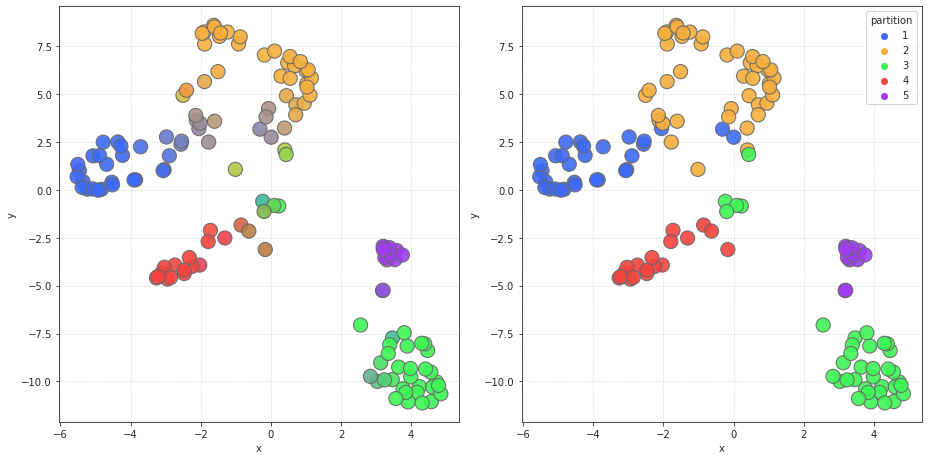

In [51]:
fig, axes = create_figure(1, 2, (13, 6.5), 'ticks')

_df = pd.DataFrame({
    'node': range(len(y_emb)),
    'x': y_emb[:, 0],
    'y': y_emb[:, 1],
    'partition': 1 + np.argmax(comps, axis=0),
    'hemisphere': hemis,
    'entropy': h,
})
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='node',
    palette=colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    legend=False,
    ax=axes[0],
)
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    palette=svinet.colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[1],
)

for ax in axes.ravel():
    ax.grid()
plt.show()

<AxesSubplot:>

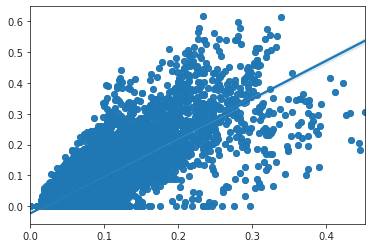

In [52]:
a = y_flat.copy().astype(float)
np.fill_diagonal(a, 0.)
a = a.ravel()
b = svinet.adjacencies[66].ravel()
sns.regplot(x=a, y=b)

In [53]:
from sklearn.manifold import MDS
y_emb = MDS(
    n_components=2,
    n_init=10,
    random_state=mice.cfg.random_state,
).fit_transform(y_flat)

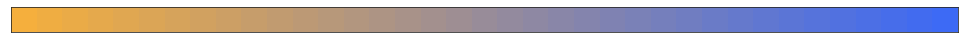

In [54]:
cmap = make_cmap([svinet.colors[2], svinet.colors[1]])

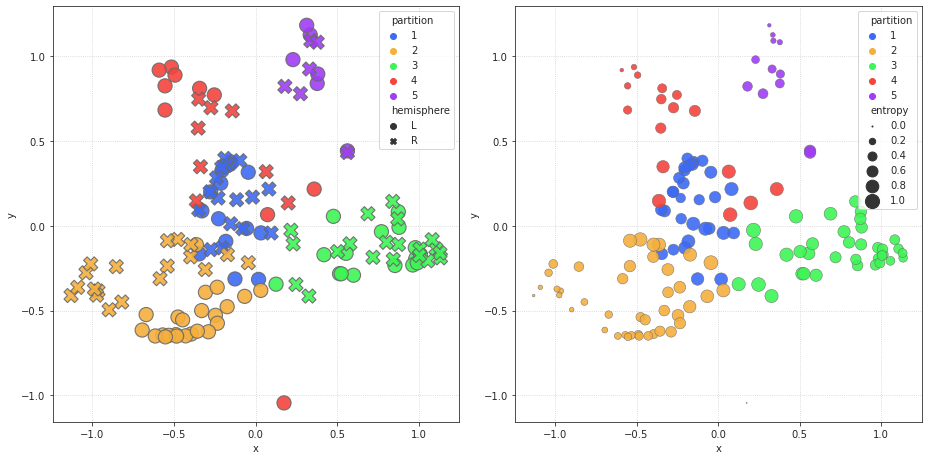

In [55]:
fig, axes = create_figure(1, 2, (13, 6.5), 'ticks')

_df = pd.DataFrame({
    'x': y_emb[:, 0],
    'y': y_emb[:, 1],
    'partition': 1 + np.argmax(comps, axis=0),
    'hemisphere': hemis,
    'entropy': h,
})
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    style='hemisphere',
    palette=svinet.colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[0],
)
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    size='entropy',
    sizes=(1, 200),
    palette=svinet.colors,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[1],
)

for ax in axes.ravel():
    ax.grid()
plt.show()

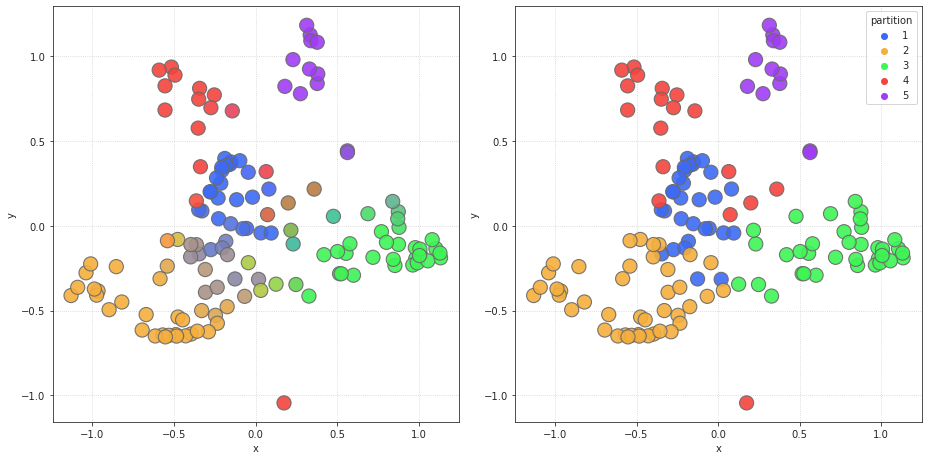

In [56]:
fig, axes = create_figure(1, 2, (13, 6.5), 'ticks')

_df = pd.DataFrame({
    'node': range(len(y_emb)),
    'x': y_emb[:, 0],
    'y': y_emb[:, 1],
    'partition': 1 + np.argmax(comps, axis=0),
    'hemisphere': hemis,
    'entropy': h,
})
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='node',
    palette=colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    legend=False,
    ax=axes[0],
)
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    palette=svinet.colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[1],
)

for ax in axes.ravel():
    ax.grid()
plt.show()

In [57]:
from karateclub import Node2Vec

model = Node2Vec(
    walk_number=20,
    walk_length=80,
    p=1.0,
    q=1.0,
    dimensions=138,
    workers=4,
    window_size=5,
    epochs=1,
    learning_rate=0.05,
    min_count=1,
    seed=mice.cfg.random_state,
)
model.fit(svinet.graphs[20])
_x_emb = model.get_embedding()

In [58]:
_x_emb.shape

(138, 138)

In [59]:
x_emb = MDS(
    n_components=2,
    n_init=10,
    random_state=mice.cfg.random_state,
).fit_transform(x_emb)

NameError: name 'x_emb' is not defined

In [ ]:
x_emb = TSNE(
    n_components=2,
    perplexity=30,
    random_state=mice.cfg.random_state,
).fit_transform(_x_emb)

In [ ]:
fig, axes = create_figure(1, 2, (13, 6.5), 'ticks')

_df = pd.DataFrame({
    'node': range(len(y_emb)),
    'x': x_emb[:, 0],
    'y': x_emb[:, 1],
    'partition': 1 + np.argmax(comps, axis=0),
    'hemisphere': hemis,
    'entropy': h,
})
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='node',
    palette=colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    legend=False,
    ax=axes[0],
)
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    palette=svinet.colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[1],
)

for ax in axes.ravel():
    ax.grid()
plt.show()

In [150]:
pi_avg = np.nanmean(pi_real, 0)
pi_avg.shape, pi_real.shape

((5, 138), (10, 5, 138))

In [151]:
y_link = np.einsum('ki, kj -> kij', pi_avg, pi_avg)
y_link.shape

(5, 138, 138)

In [152]:
y_link[:, 51, 25] - pi_avg[:, 51] * pi_avg[:, 25]

array([0., 0., 0., 0., 0.], dtype=float128)

In [153]:
y_link[:, 25, 25]

array([0.07018516, 0.03134108, 0.01234603, 0.1420662 , 0.00490163],
      dtype=float128)

In [82]:
y_link_flat = [
    np.expand_dims(y_link[i][np.triu_indices(pi_avg.shape[1])], 0)
    for i in range(k)
]
y_link_flat = np.concatenate(y_link_flat)
y_link_flat.shape

(5, 9591)

In [83]:
adj_link = y_link_flat.T @ y_link_flat

In [84]:
np.min(adj_link), np.max(adj_link)

(0.00012643371377347815501, 0.49415058299294663193)

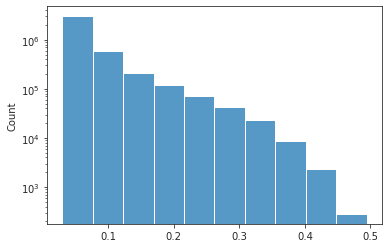

In [85]:
sns.histplot(adj_link[adj_link > 0.03], bins=10)
plt.yscale('log')

## Posterior update

In [180]:
group['gam'].shape, group['pi'].shape

((11, 138), (11, 138))

In [181]:
mode = np.zeros_like(group['gam'])
for node in range(group['gam'].shape[1]):
    for i in range(k):
        mode[i, node] = (group['gam'][i, node] - 1) / (group['gam'][:, node].sum() - k)